In [7]:
import cv2
import numpy as np
from neuralnetworks.convlstm import ConvLSTM

In [8]:
from video_processing.prepare_data import extract_frames, prepare_train_data

In [9]:
frames = extract_frames(video_path="/Users/chrishon/capstone-camera-traps/resources/videos/FH102_02 (1).avi")

In [10]:
X,y = prepare_train_data(frames[:len(frames)//100])

In [11]:
import matplotlib.pyplot as plt

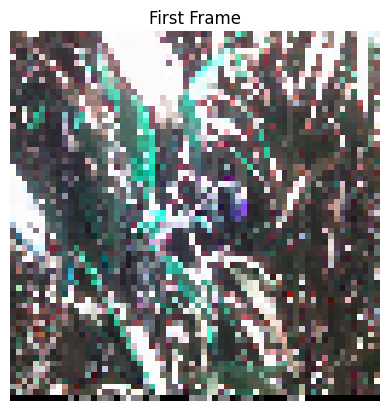

In [12]:
# Plot the first frame to visualize
plt.imshow(frames[20])  # Display the first frame
plt.title("First Frame")
plt.axis("off")  # Hide axes for better view
plt.show()

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader objects for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [16]:
# Model parameters
input_dim = 3
hidden_dim = 64
kernel_size = 3
num_layers = 2
model = ConvLSTM(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
device = torch.device('cuda') if  torch.cuda.is_available() else torch.device('cpu')

In [18]:
# Training loop
num_epochs = 10
batch_size = 8

for epoch in range(num_epochs):
    for batch_x, batch_y in train_loader: 
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.0674
Epoch [2/10], Loss: 0.0451
Epoch [3/10], Loss: 0.0271
Epoch [4/10], Loss: 0.0173
Epoch [5/10], Loss: 0.0196
Epoch [6/10], Loss: 0.0146
Epoch [7/10], Loss: 0.0171
Epoch [8/10], Loss: 0.0106
Epoch [9/10], Loss: 0.0108
Epoch [10/10], Loss: 0.0111


In [28]:
def compute_average_pixel_distance(frames1, frames2):
    frames1 = frames1.cpu().numpy() if isinstance(frames1, torch.Tensor) else frames1
    frames2 = frames2.cpu().numpy() if isinstance(frames2, torch.Tensor) else frames2
    distances = []
    for i in range(1, len(frames1[0])):
        # Calculate pixel-wise absolute differences
        diff = np.abs(frames1[i] - frames2[i-1])
        avg_distance = np.mean(diff)  # Average over all pixels
        distances.append(avg_distance)
    return distances


In [29]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
with torch.no_grad():
    prediction = model(X_test_tensor)
prediction.shape


torch.Size([21, 3, 64, 64])

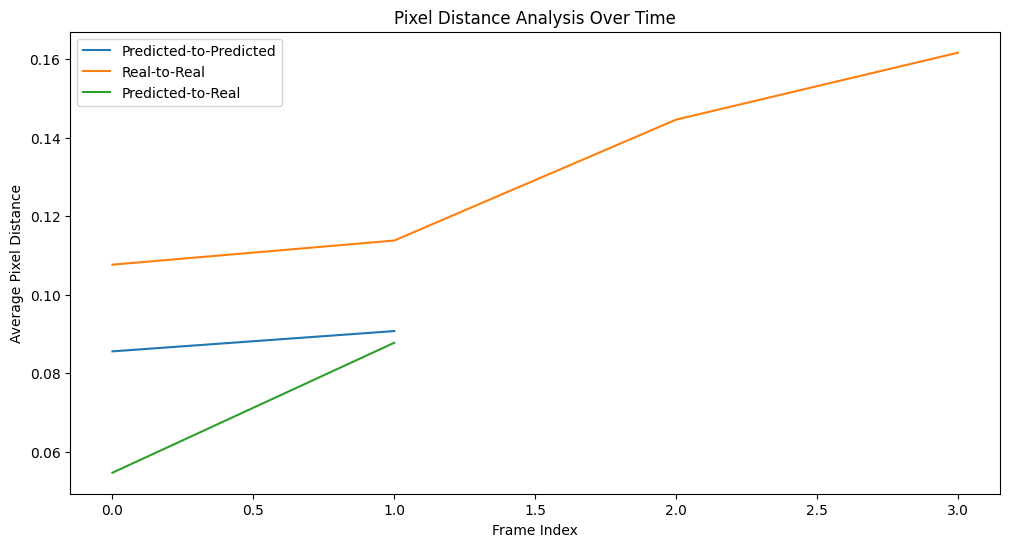

In [30]:
# Compute pixel distances
predicted_to_predicted = compute_average_pixel_distance(prediction, prediction)
real_to_real = compute_average_pixel_distance(X_test, X_test)
predicted_to_real = compute_average_pixel_distance(prediction, y_test[1::])

# Plotting the distances
plt.figure(figsize=(12, 6))
plt.plot(predicted_to_predicted, label="Predicted-to-Predicted")
plt.plot(real_to_real, label="Real-to-Real")
plt.plot(predicted_to_real, label="Predicted-to-Real")
plt.xlabel("Frame Index")
plt.ylabel("Average Pixel Distance")
plt.title("Pixel Distance Analysis Over Time")
plt.legend()
plt.show()